# 1. Overview

The goal of this project is to predict the sentiment of IMDB movie reviews (positive or negative) using machine learning. The pipeline includes:

*   Text preprocessing and cleaning

*   Bag-of-Words feature extraction

*   Model training using XGBoost

*   Evaluation through accuracy, F1 score, cross-validation, and feature importance

*   Testing on custom reviews

This notebook demonstrates the application of NLP and machine learning to a real-world text dataset, providing both predictive performance and interpretability.

# 2. Data preparation


## 2.1 Loading the Dataset

In [28]:
import numpy as np
import pandas as pd

dataset = dataset1 = pd.read_csv('/content/drive/MyDrive/AI/1. Machine learning/ML projects/NLP sentiment analysis/IMDB Dataset.csv')

# Make a subset of dataset (Used for training because the original is computationnally expensive)
subset_size = 50000 # Full dataset for the final testing and results, change if needed
subset = dataset.iloc[:subset_size, :]

dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2.2 Text preprocessing

Text data requires cleaning to remove noise and prepare it for modeling. Steps include:

*   Remove HTML tags `<br />` and non-alphabetic characters

*   Convert to lowercase

*   Remove stopwords, keeping negations (e.g., “not”)

*   Lemmatize words to their dictionary form

In [ ]:
import re # Regular Expression
import nltk # Natural Language Toolkit
nltk.download('stopwords')
from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

corpus = []
n = len(subset)
for i in range(0, n):
  review = re.sub('<br />' or  '[^a-zA-Z]', ' ', subset['review'][i])
  review = review.lower()
  review = review.split()

# ps = PorterStemmer()
  lm = WordNetLemmatizer()

  all_stopwords = stopwords.words('english')
  review = [lm.lemmatize(word) for word in review if not word in set(all_stopwords)]
           #lm.lemmatize
           #ps.stem for stemming, could be used but I noticed a smaller precision for the model

  review = ' '.join(review)
  corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


The practical distinction between stemming and lemmatization is that, where stemming merely removes common suffixes from the end of word tokens, lemmatization ensures the output word is an existing normalized form of the word (for example, lemma) that can be found in the dictionary.

# 3. Feature Engineering & Modeling

## 3.1 Bag-of-words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#Tokenization
cv = CountVectorizer(max_features = 1400)

# Matrix of features
X = cv.fit_transform(corpus).toarray() #expected to be an array
y = subset.iloc[:,-1]

max_features = 1400 was chosen after cross validation sweep


```
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

for mf in [1000, 1200,1400,1600,1800,5000,10000]:
    cv = CountVectorizer(max_features=mf)
    X = cv.fit_transform(corpus).toarray()
    scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')
    print(f"max_features={mf}, mean accuracy={scores.mean():.4f}")

```
Best mean accuracy was for:
max_features=1400


## 3.2 Encoding dependent variable

In [ ]:
import pandas as pd
label_map = {'negative': 0, 'positive': 1}
y = pd.Series(y).map(label_map).values

In [ ]:
y

array([1, 1, 1, ..., 0, 0, 0])

## 3.3 Splitting the subset into the Training set and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## 3.4 XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier
classifier = XGBClassifier(
    eval_metric='logloss',
    max_depth = 10,
    min_child_weight = 1.76,

    colsample_bytree = 0.58,
    subsample = 0.88,

    n_estimators = 200
)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.58, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1.76, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

# 4. Hyperparameter Tuning

## 4.1 Tree Complexity: max_depth & min_child_weight

In [ ]:
param_grid = {
    'max_depth': [10,11,12],
    'min_child_weight': [1.76]
}
grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best accuracy:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

NameError: name 'GridSearchCV' is not defined

**Resultat:**

Best parameters: max_depth=10, min_child_weight=1.76.

## 4.2 Learning Rate & Estimators

In [ ]:
param_grid = {
    'learning_rate': np.linspace(0.045,0.055,6),
    'n_estimators': [200]
}
grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best accuracy:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


**Resultat:**

Best parameters: learning_rate=0.05, n_estimators=200

## 4.3 Sampling Parameters: subsample & colsample_bytree

In [ ]:
param_grid = {
    'subsample': np.linspace(0.87,0.89,6),
    'colsample_bytree': np.linspace(0.57,0.59,6)
}
grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=10, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best accuracy:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)


**Resultat:**

Best parameters: subsample=0.88, colsample_bytree=0.58.

# 5. Model evaluations

The model achieved strong performance with high accuracy and robustness. Key evaluation metrics include the confusion matrix, cross-validation results, and feature importance analysis. These results highlight the model’s reliability in predicting loan default and the factors most influencing the outcome.

## 5.1 Making the Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Accuracy : {}".format(accuracy_score(y_test, y_pred)) )
print("F1 score : {}".format(f1_score(y_test, y_pred)) )

[[4307  728]
 [ 672 4293]]
Accuracy : 0.86
F1 score : 0.8598037252153015


The model correctly identifies review sentiments. Some misclassifications remain, but the balance shows it is reliable for risk assessment.

## 5.2 Applying k-Fold Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Mean accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Mean accuracy: 86.04 %
Standard Deviation: 0.46 %


The 10-fold cross-validation shows consistent accuracy across folds, confirming that the model generalizes well and is not overfitting.

## 5.3 Feature importance analysis

1229


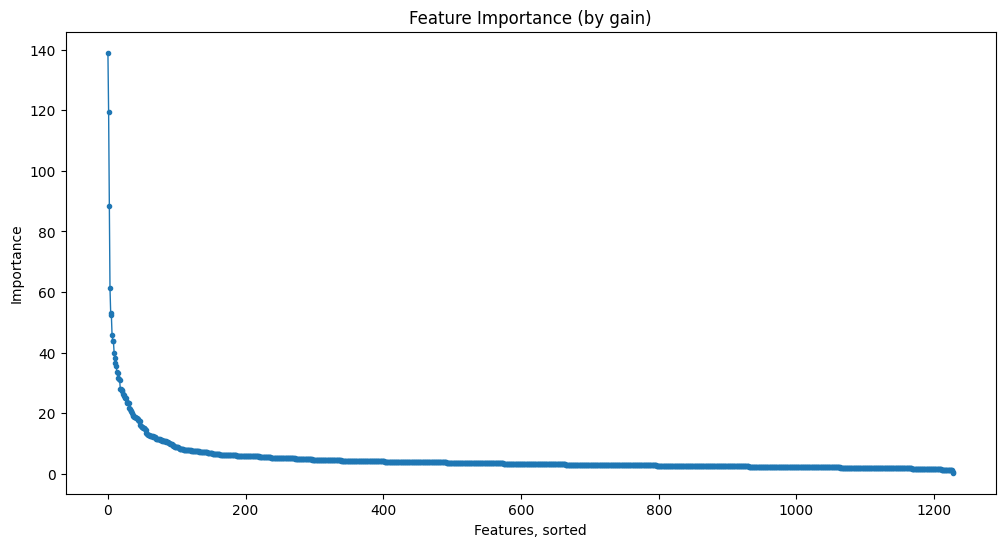

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract importance scores
importance = classifier.get_booster().get_score(importance_type="gain")
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by="importance", ascending=False)

# Sort by importance
importance_sorted = importance_df.sort_values(by="importance", ascending=False)

# Line plot
plt.figure(figsize=(12,6))
plt.plot(range(len(importance_sorted)), importance_sorted["importance"], marker='o', markersize=3, linewidth=1)
plt.title("Feature Importance (by gain)")
plt.xlabel("Features, sorted")
plt.ylabel("Importance")

print(len(importance_df))

plt.show()

In [ ]:
feature_names = cv.get_feature_names_out()

# adding words to the DataFrame of importance:
importance_df["word"] = importance_df["feature"].apply(
    lambda f: feature_names[int(f[1:])] )

print("The most important 30 features: ")
print(importance_df.head(30))

The most important 30 features: 
     feature  importance         word
1210   f1379  138.966431        worst
1169   f1334  119.273666        waste
83       f97   88.476814        awful
1064   f1220   61.228043     terrible
123     f145   53.119095       boring
87      f101   52.421665          bad
817     f937   45.783249       poorly
349     f410   43.947594    excellent
1027   f1173   43.679852       stupid
1203   f1371   39.978146    wonderful
230     f275   38.301800         crap
1209   f1378   36.652653        worse
591     f678   35.676437         lame
1035   f1186   33.496872       superb
512     f592   33.131062     horrible
79       f93   31.609798        avoid
816     f936   31.317942         poor
676     f776   30.971231         mess
1170   f1335   27.988398       wasted
887    f1017   27.897789   ridiculous
376     f439   27.750269    fantastic
300     f359   27.497896         dull
770     f881   26.288609  outstanding
436     f513   26.139240          gem
1038   f1190   25

the model highlights the most influential features among the 1,400 initially selected, with only 1,229 contributing meaningfully to the classification outcome.

# 6. Testing custom review (feel free!!)

Write a review about a movie:

In [ ]:
your_review = "awful movie terrible casting"

def preprocess_review(text):
    text = re.sub('[^a-zA-Z]' or '<br />', ' ', text)
    text = text.lower()
    words = text.split()
    lm = WordNetLemmatizer()
    all_stopwords = stopwords.words('english')
    to_remove = ['not', 'again', "don't", "doesn't", "hadn't", "hasn't", "haven't",
                 "won't",'wouldn',"wouldn't","weren't","wasn't", "shouldn't",
                 "should've", 'off', 'on', "isn't", "so"]
    for word in to_remove:
        if word in all_stopwords:
            all_stopwords.remove(word)

    words = [lm.lemmatize(w) for w in words if w not in set(all_stopwords)]
    return ' '.join(words)

processed_review = preprocess_review(your_review)
X_new = cv.transform([processed_review]).toarray()

prediction = classifier.predict(X_new)
prediction_proba = classifier.predict_proba(X_new)

print("Predicted sentiment:", "positive" if prediction[0]==1 else "negative")
print()
print("Prediction probabilities:")
print("- Positive: " + f"{float(prediction_proba[0][1]*100):.2f} %")
print("- Negative: " + f"{float(prediction_proba[0][0]*100):.2f} %")


Predicted sentiment: negative

Prediction probabilities:
- Positive: 0.69 %
- Negative: 99.31 %


# 7. Conclusions

The project demonstrates that machine learning can be successfully applied to sentiment analysis of movie reviews, achieving a solid accuracy of around 85%. Beyond predictive performance, the model highlights the most influential features among the 1,400 initially selected, with only 1,229 contributing meaningfully to the classification outcome. This shows that the model is capable of automatically filtering out less relevant words and focusing on the most significant expressions that drive sentiment polarity.

By identifying these key features, the project not only improves predictive accuracy but also enhances interpretability, offering insights into the linguistic patterns that distinguish positive from negative reviews. This foundation could be extended into a real-time sentiment analysis system or integrated into review platforms and recommendation engines, enabling richer user experiences and more informed content moderation.

## Model export

In [ ]:
import joblib
joblib.dump(classifier, "/content/drive/MyDrive/Machine learning/ML projects/NLP sentiment analysis/sentiment_app/sentiment_model.pkl")

joblib.dump(cv, "/content/drive/MyDrive/Machine learning/ML projects/NLP sentiment analysis/sentiment_app/countvectorizer.pkl")

['/content/drive/MyDrive/Machine learning/ML projects/NLP sentiment analysis/sentiment_app/countvectorizer.pkl']